In [2]:
import pickle 
import os 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from pathlib import Path 

### GP results

In [15]:
parkinson = pd.read_parquet(
    Path('GP/test') / 'synthetic10' / 'dalex' / 'checkpoint_testing_split3_1.parquet'
)

parkinson

,dataset_name,split_id,trial_id,seed,rmse_test,mae_test,r2_test,gen_gap_per,nodes,depth,train_rmse,overfit_per,time,latex_repr
0,synthetic10,3,0,0,1.237803,0.816764,0.422076,9.936014,87,8,1.168007,-5.975691,36.515423,\begin{equation}\frac{\frac{2 x_{0}}{\sqrt{\le...
1,synthetic10,3,1,1,1.216253,0.817607,0.442024,8.022034,99,8,1.133464,-7.304122,42.663223,\begin{equation}\frac{\frac{x_{0}}{\sqrt{\left...
2,synthetic10,3,2,2,1.159008,0.784198,0.493313,2.937749,125,8,1.103174,-5.061217,53.721139,\begin{equation}\frac{1.91192150517511 x_{0} +...
3,synthetic10,3,3,3,1.249253,0.867804,0.411335,10.952901,67,8,1.239653,-0.774401,45.622540,\begin{equation}\frac{0.609756097560975 x_{0} ...
4,synthetic10,3,4,4,1.277974,0.797190,0.383956,13.503802,85,8,1.146157,-11.500808,43.241618,\begin{equation}\frac{\frac{\frac{x_{1}}{\sqrt...
5,synthetic10,3,5,5,1.485587,0.936828,0.167540,31.943021,79,8,1.328857,-11.794344,57.593472,\begin{equation}\frac{0.957826285221151 x_{0}}...
6,synthetic10,3,6,6,1.148982,0.767112,0.502040,2.047347,45,8,1.259188,8.752148,24.343059,\begin{equation}\frac{x_{2} \left(x_{1} + 3 x_...
7,synthetic10,3,7,7,1.460045,0.839469,0.195919,29.674502,93,8,1.215325,-20.136206,58.103504,\begin{equation}\frac{2 x_{0}}{\sqrt{\left(x_{...
8,synthetic10,3,8,8,1.274101,0.971901,0.387684,13.159817,49,8,1.231593,-3.451489,33.087942,\begin{equation}\frac{0.941176470588235 x_{0} ...
9,synthetic10,3,9,9,1.321013,0.843781,0.341764,17.326345,103,8,1.130549,-16.847085,44.731327,\begin{equation}\frac{\frac{x_{0}}{\sqrt{x_{0}...


In [3]:
for dataset in os.listdir('GP/test'):
    print(dataset)

airfoil
bioav
boston
concrete_strength
diabetes
efficiency_heating
forest_fires
istanbul
ld50
parkinson_updrs
ppb
resid_build_sale_price
synthetic1
synthetic10
synthetic11
synthetic12
synthetic2
synthetic3
synthetic4
synthetic5
synthetic6
synthetic7
synthetic8
synthetic9


### Multi results 

### PS-Tree results

In [36]:
for dataset in os.listdir('hp_results'): 
    try: 
        dalex = pd.read_parquet(f'hp_results/{dataset}/dalex_tuning_results1.parquet')
        dalex_fast_rand = pd.read_parquet(f'hp_results/{dataset}/dalex_fast_rand_tuning_results1.parquet')
    except:
        # print(f"Skipping {dataset} due to missing files.")
        continue

    print(dataset, ':',  100*(1 - dalex_fast_rand['cv_elapsed_sec'].mean() / dalex['cv_elapsed_sec'].mean()))

airfoil : 1.9020636901335042
concrete_strength : 6.48480492013741
diabetes : 18.328678754123516
efficiency_heating : 10.595115326239613
forest_fires : -1.1091620659539059
istanbul : -11.64886003009351
ld50 : -15.65352179343722
ppb : -6.124567953310933
synthetic1 : 2.509329883110478
synthetic10 : 1.0070227674329635
synthetic11 : 7.405794998432558
synthetic12 : 1.4714452503434505
synthetic2 : -2.203753852658341
synthetic3 : -4.159221466232732
synthetic4 : -51.18565416711047
synthetic5 : 19.216293458451872
synthetic6 : 1.3990375411969125
synthetic7 : 12.358719431999921
synthetic8 : 1.1566455823506794


In [41]:
dalex

,dataset_name,split_id,trial_id,seed,init_depth,max_depth,p_xo,prob_const,prob_terminal,particularity_pressure,mean_cv_rmse,std_cv_rmse,mean_cv_nodes,cv_elapsed_sec,std_time,pareto_front
0,synthetic8,0,1,0,2,8,0.853280,0.228692,0.854176,11.466108,5.664531,2.082467,87.25,331.819700,29.626462,"[[6.8577177068975725, 45.0], [7.85286357928533..."
1,synthetic8,0,2,0,2,7,0.689260,0.108507,0.681797,6.479458,5.053201,1.430760,67.50,298.509169,23.366431,"[[6.528874828062294, 70.0], [6.528874828062294..."
2,synthetic8,0,3,0,2,8,0.743993,0.158918,0.850824,3.743053,5.100863,1.397352,100.75,507.716050,42.103290,"[[6.222642683142922, 127.0], [6.22264268314292..."
3,synthetic8,0,4,0,2,8,0.710472,0.243573,0.642105,30.078221,5.520938,1.559730,76.50,359.812979,64.153794,"[[3.1758281531822568, 135.0], [3.1758281531822..."
4,synthetic8,0,5,0,2,7,0.840273,0.178072,0.803664,16.762287,5.650169,1.093150,53.75,256.247012,24.059693,"[[3.800061644790354, 69.0], [4.199545172007316..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,synthetic8,3,16,0,2,8,0.710513,0.243722,0.642442,30.151922,5.049053,1.831331,88.50,378.049117,34.612394,"[[2.3029056509501395, 138.0], [2.3029056509501..."
76,synthetic8,3,17,0,2,8,0.710090,0.243409,0.639537,30.042420,5.121645,1.748584,86.25,331.747060,44.665481,"[[2.336815251657583, 103.0], [2.33911108207208..."
77,synthetic8,3,18,0,2,8,0.697882,0.219017,0.642084,26.980484,5.328688,1.787596,93.25,224.287313,23.501602,"[[6.152443580045897, 148.0], [6.57966685240916..."
78,synthetic8,3,19,0,2,8,0.711512,0.243244,0.642148,29.948151,5.274448,2.188242,72.50,221.074809,33.236211,"[[5.94025151164139, 52.0], [7.357934871761248,..."


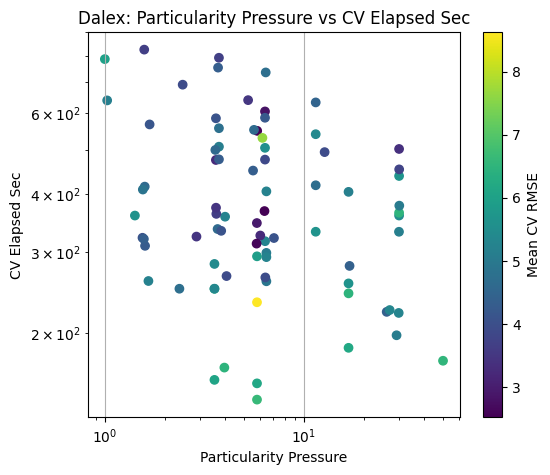

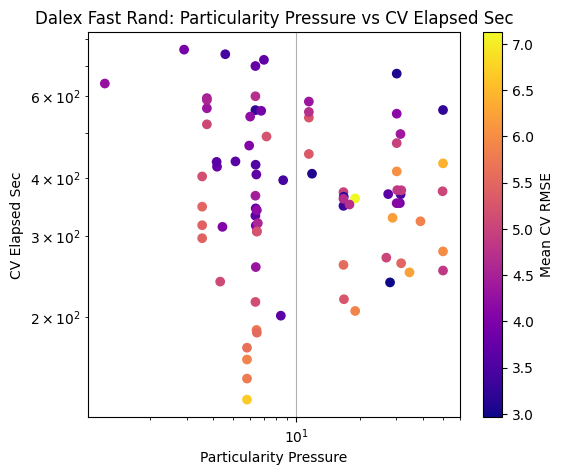

In [49]:
import matplotlib.pyplot as plt

# Plot for Dalex
plt.figure(figsize=(6, 5))
plt.scatter(dalex['particularity_pressure'], dalex['cv_elapsed_sec'], c=dalex['mean_cv_rmse'], cmap='viridis')
plt.colorbar(label='Mean CV RMSE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Particularity Pressure')
plt.ylabel('CV Elapsed Sec')
plt.title('Dalex: Particularity Pressure vs CV Elapsed Sec')
plt.grid(True)
plt.show()

# Plot for Dalex Fast Rand
plt.figure(figsize=(6, 5))
plt.scatter(dalex_fast_rand['particularity_pressure'], dalex_fast_rand['cv_elapsed_sec'], c=dalex_fast_rand['mean_cv_rmse'], cmap='plasma')
plt.colorbar(label='Mean CV RMSE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Particularity Pressure')
plt.ylabel('CV Elapsed Sec')
plt.title('Dalex Fast Rand: Particularity Pressure vs CV Elapsed Sec')
plt.grid(True)
plt.show()


In [ ]:
for dataset in os.listdir('test_results'): 
    try: 
        dalex = pd.read_parquet(f'test_results/{dataset}/dalex_test_results1.parquet') 
        dalex_fast_rand = pd.read_parquet(f'test_results/{dataset}/dalex_fast_rand_test_results1.parquet')
    except:
        # print(f"Skipping {dataset} due to missing files.")
        continue

    time_diff = round(100*(1 - dalex_fast_rand['time'].median() / dalex['time'].median()),2)
    rmse_diff = round(100*(1 - dalex_fast_rand['rmse_test'].median() / dalex['rmse_test'].median()),2)
    r2_diff = round(100*(1 - dalex_fast_rand['r2_test'].median() / dalex['r2_test'].median()),2)
    # print(dataset, ':',  time_diff, '% || ', rmse_diff, '%', '||', r2_diff, '%')

airfoil
5.934357336795805 5.829884591484707
concrete_strength
7.3690270065039805 7.629800818665171
diabetes
58.94981679193566 58.25903327010067
efficiency_heating
2.580159045783668 2.7892965006985913
forest_fires
1.5628908458296074 1.5815226905206141
istanbul
0.014846520043498316 0.014765495999743356
ld50
2423.1567506172296 2081.713726986255
ppb
33.02609352168636 29.937166029863597
synthetic1
0.9863371531907272 0.8242726255109991
synthetic10
1.4860957412219136 1.4456733812228326
synthetic11
12.923598198684418 9.041815407731875
synthetic12
878.9108623220552 30.750155861295298
synthetic2
0.21137031926459351 0.15974413825244296
synthetic3
0.650642998452843 0.6460260862703182
synthetic4
0.3607951475865566 0.005031132849602611
synthetic5
0.41956874969150554 0.29324838857863067
synthetic6
10.064265206526642 8.736400935857638
synthetic7
0.06784041589786471 0.0713728573329653
synthetic8
3.8576855462485384 4.586099736644421


In [27]:
dalex

,dataset_name,split_id,trial_id,seed,rmse_test,mae_test,r2_test,generalization_gap_%,total_nodes,depth,train_rmse,overfitting_%,time,latex_repr
0,synthetic8,0,0,0,4.534905,3.969344,0.910530,24.213559,124,8,4.452353,-1.854120,104.692198,\begin{equation}\frac{\left(4 x_{0}^{2} x_{1} ...
1,synthetic8,0,1,0,5.744202,5.054431,0.856451,57.336888,125,8,5.706703,-0.657113,96.566022,\begin{equation}\frac{2 x_{1} + \left(x_{0} - ...
2,synthetic8,0,2,0,4.644958,4.037506,0.906135,27.227986,166,8,4.583887,-1.332314,120.878093,\begin{equation}\frac{\left(x_{0}^{2} \left(x_...
3,synthetic8,0,3,0,5.624644,4.747390,0.862364,54.062110,114,8,5.542322,-1.485338,73.169287,\begin{equation}1.49071198499986 x_{0} + 1.490...
4,synthetic8,0,4,0,5.020264,4.256187,0.890354,37.507819,85,8,4.884023,-2.789521,85.043855,\begin{equation}\frac{\left(x_{0}^{2} \left(0....
5,synthetic8,0,5,0,5.591817,4.949332,0.863966,53.162956,217,8,5.572176,-0.352485,167.605884,\begin{equation}\frac{x_{0} \left(x_{0} - 0.95...
6,synthetic8,0,6,0,5.694276,4.405013,0.858935,55.969380,70,8,5.352764,-6.380103,58.657697,\begin{equation}\left(x_{0} + 3 x_{2} - \left|...
7,synthetic8,0,7,0,4.510528,3.708910,0.911489,23.545856,117,8,4.301572,-4.857658,87.492496,\begin{equation}\frac{0.896450598455574 \left(...
8,synthetic8,0,8,0,4.218609,3.427014,0.922575,15.550046,110,8,4.090671,-3.127574,88.275071,\begin{equation}\frac{\left(x_{0} \left(x_{0} ...
9,synthetic8,0,9,0,5.611611,4.803733,0.863001,53.705143,129,8,5.505163,-1.933602,88.039748,\begin{equation}\left(x_{0} + 0.5 x_{2} - \lef...
